In [7]:
%matplotlib inline
import inspect, os, sys, copy, pytz, re, glob, math
import simplejson as json
import pandas as pd
from dateutil import parser
import datetime
import matplotlib.pyplot as plt   # Matplotlib for plotting
import matplotlib.dates as md
import numpy as np
import seaborn as sns
import csv
import statsmodels.formula.api as smf  # for doing statistical regression
import statsmodels.api as sm      # access to the wider statsmodels library, including R datasets
from collections import Counter, defaultdict
utc=pytz.UTC

ENV = "production"
BASE_DIR = "/home/nathan/reddit_archive/"
sys.path.append(BASE_DIR)

### FILTER OUT DEPRECATION WARNINGS ASSOCIATED WITH DECORATORS
# https://github.com/ipython/ipython/issues/9242
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning, message='.*use @default decorator instead.*')

In [8]:
posts_filename = "IAmA_posts_2017.json"
comments_filename = "IAmA_comments_2017.json"

In [46]:
all_posts = []
post_ids = set()
post_count = 0 
with open(os.path.join(BASE_DIR, "selected_output", posts_filename), "r") as f:
    for line in f:
        item = json.loads(line)
        if(item['id'] not in post_ids):
            item['created'] = datetime.datetime.utcfromtimestamp(float(item['created_utc']))
            lbody  = item['selftext'].lower()
            ltitle = item['title'].lower()
            item['AMA'] = False
            if(lbody.find("proof") > - 1 and ltitle.find("request") ==-1):
                item['AMA'] = True
            all_posts.append(item)
            post_ids.add(item['id'])
        post_count += 1

        
all_posts = sorted(all_posts, key = lambda x: x['created'])        

all_comments = []
comment_ids = set()
comment_count = 0
with open(os.path.join(BASE_DIR, "selected_output", comments_filename), "r") as f:
    for line in f:
        item = json.loads(line)
        if(item['id'] not in comment_ids):
            item['created'] = datetime.datetime.utcfromtimestamp(float(item['created_utc']))
            item['body.charlength'] = len(item['body'])
            item['body.includes.question'] = item['body'].find("?") > -1
            item['toplevel'] = item['parent_id'] == item['link_id']
            item['body'] = None
            all_comments.append(item)
            comment_ids.add(item['id'])
        comment_count += 1
all_comments = sorted(all_comments, key = lambda x: x['created'])        

print("Loaded {0} Posts and {1} Comments".format(len(all_posts), len(all_comments)))
print("Loaded {0} Post lines and {1} Comment lines".format(post_count, comment_count))
#print("Posts have a mean of {0} comments".format(np.mean([len(x) for x in all_comments.values()])))

Loaded 23079 Posts and 1397172 Comments
Loaded 23767 Post lines and 1670538 Comment lines


In [104]:
ama_posts = {}
for item in all_posts:
    post = copy.copy(item)
    del item['selftext']
    if post['AMA']:
        post['num.comments'] = 0
        post['num.toplevel.comments'] = 0
        post['num.toplevel.nonquestions'] = 0
        ama_posts[post['id']] = post
        
ama_post_ids = [x['id'] for x in ama_posts.values()]

In [105]:
for comment in all_comments:
    link_id = comment['link_id'].replace("t3_", "")
    if link_id in ama_post_ids:
        post = ama_posts[link_id]
        post['num.comments'] += 1
        if(comment['toplevel']):
            post['num.toplevel.comments'] += 1
            if(comment['body.includes.question'] == False):
                post['num.toplevel.nonquestions'] +=1

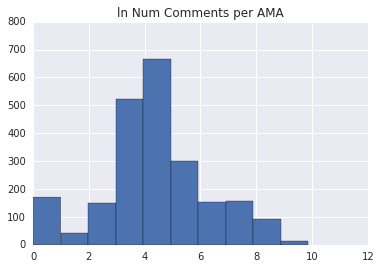

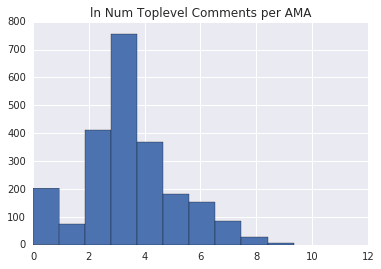

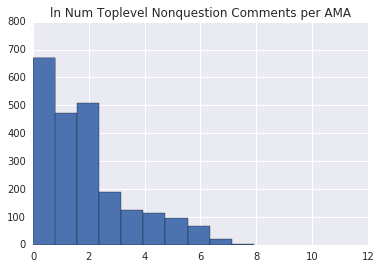

In [110]:
plt.hist([math.log1p(x['num.comments']) for x in ama_posts.values()])
plt.title("ln Num Comments per AMA")
plt.xlim(0,12)
plt.ylim(0,800)
plt.show()
plt.hist([math.log1p(x['num.toplevel.comments']) for x in ama_posts.values()])
plt.title("ln Num Toplevel Comments per AMA")
plt.xlim(0,12)
plt.ylim(0,800)
plt.show()
plt.hist([math.log1p(x['num.toplevel.nonquestions']) for x in ama_posts.values()])
plt.title("ln Num Toplevel Nonquestion Comments per AMA")
plt.xlim(0,12)
plt.ylim(0,800)
plt.show()

### Write Posts to DataFrame

In [107]:
list(ama_posts.values())[0]

{'AMA': True,
 'archived': False,
 'author': 'moldovangrandma',
 'created': datetime.datetime(2017, 4, 21, 15, 18, 4),
 'created_utc': '1492787884',
 'domain': 'self.IAmA',
 'gilded': '0',
 'hide_score': False,
 'id': '66ptzi',
 'is_self': True,
 'link_flair_css_class': 'unique',
 'link_flair_text': 'Unique Experience',
 'num.comments': 2500,
 'num.toplevel.comments': 507,
 'num.toplevel.nonquestions': 166,
 'num_comments': '2343',
 'over_18': False,
 'permalink': '/r/IAmA/comments/66ptzi/i_am_a_74_year_old_grandma_from_moldova_the/',
 'quarantine': False,
 'retrieved_on': '1494619745',
 'score': '22092',
 'selftext': None,
 'stickied': False,
 'subreddit': 'IAmA',
 'subreddit_id': 't5_2qzb6',
 'thumbnail': 'self',
 'title': 'I am a 74 year old Grandma from Moldova, the poorest country in Europe. I survived WWII, outlived 3 brothers who died of hunger and lived through the Soviet Union. AMA!',
 'url': 'https://www.reddit.com/r/IAmA/comments/66ptzi/i_am_a_74_year_old_grandma_from_moldov

In [108]:
pd.DataFrame(list(ama_posts.values())).to_csv("iama/iama_AMAs_01.01.2017-12.31.2017.csv")